In [71]:
import pandas as pd
from path import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [3]:
DATA_DIR = Path("/home/sharad/data/metasense/la/")

In [244]:
data = pd.read_csv(DATA_DIR / "all_data.csv", index_col='datetime', parse_dates=True)
data = data.iloc[40:]
data['temperature-F'] = 9.0 / 5.0 * data['temperature'] + 32
data['co'] = data['co-W'] - data['co-A']

## Sanity Check

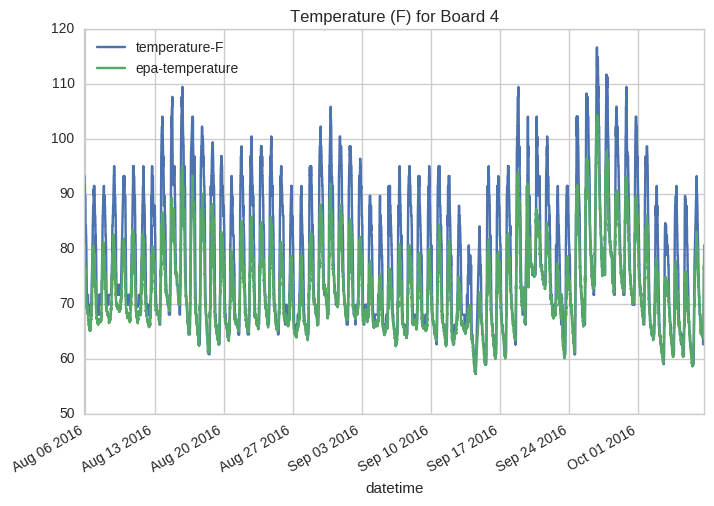

In [245]:
data[['temperature-F', 'epa-temperature']].plot()
plt.title("Temperature (F) for Board 4")
plt.show()

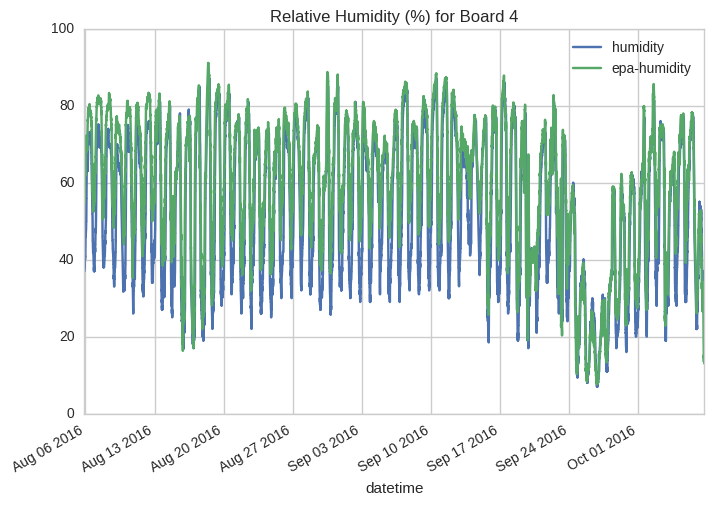

In [246]:
data[['humidity', 'epa-humidity']].plot()
plt.title("Relative Humidity (%) for Board 4")
plt.show()

# Training with board 4

Let's see how models perform. We'll train on the first two weeks and evaluate on the rest of the data.

In [258]:
train_data, test_data = data.loc[:"2016-08-18"], data.loc["2016-08-18":]
def benchmark(name, cf, features, output):
    cf.fit(train_data[features], train_data[output])
    error = (test_data[output] - cf.predict(test_data[features])) ** 2
    print("%s: %f" % (name, np.sqrt(error.mean())))
    return (name, error, cf, features)

BENCHMARKS = [
    ("Linear[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', LinearRegression())])),
    ("Linear[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', LinearRegression())])),
    ("Linear[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', LinearRegression())])),
    ("Ridge[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Ridge())])),
    ("Ridge[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Ridge())])),
    ("Ridge[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Ridge())])),
    ("Lasso[1]", Pipeline([('poly', PolynomialFeatures(1)), ('cf', Lasso())])),
    ("Lasso[2]", Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])),
    ("Lasso[3]", Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso())])),
]
CO_FEATURES = (["co-A", "co-W", "temperature", "humidity"], "epa-co")
O3_FEATURES = (["o3-A", "o3-W", "co-A", "co-W", "temperature", "humidity"], "epa-o3")
NO2_FEATURES = (["o3-A", "o3-W", "no2-A", "no2-W", "co-A", "co-W", "temperature", "humidity"], "epa-no2")
def benchmark_full(features, output):
    results = {}
    best = (float('inf'), None)
    for name, cf in BENCHMARKS:
        results[name] = benchmark(name, cf, features, output)
        _, error, _, _ = results[name]
        avg_error = np.sqrt(error.mean())
        if avg_error < best[0]:
            best = (avg_error, results[name])
    print_function(best[1])
    return best
def print_function(result):
    name, _, cf, features = result
    poly = cf.named_steps['poly']
    func = cf.named_steps['cf'].coef_
    intercept = cf.named_steps['cf'].intercept_
    print("f(x) = ", end="")
    terms = []
    for term in poly.powers_:
        polyterms = ["%s^%u" % (features[i], power) if power > 1 else "%s" % features[i] for i, power in enumerate(term) if power > 0]
        terms.append(" * ".join(polyterms))
    print(" + ".join(["%.2E * %s" % (c, t) for c, t in zip(func, terms) if c != 0.0] + [str(intercept)]))

Linear[1]: 0.116947
Linear[2]: 0.112902
Linear[3]: 0.244131
Ridge[1]: 0.116947
Ridge[2]: 0.112899
Ridge[3]: 0.276659
Lasso[1]: 0.128670
Lasso[2]: 0.112866
Lasso[3]: 0.114190
f(x) = -1.80E-05 * co-A^2 + 2.63E-05 * co-A * co-W + -4.42E-05 * co-A * humidity + -3.88E-06 * co-W^2 + -3.16E-05 * co-W * temperature + 1.01E-05 * co-W * humidity + 4.85E-05 * humidity^2 + 0.112430869326


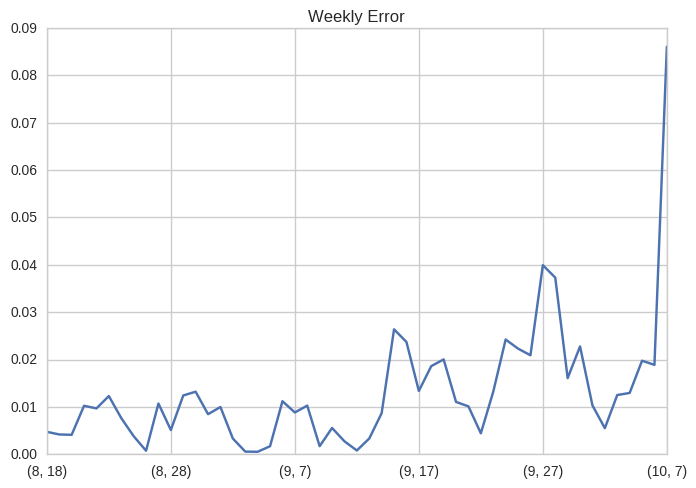

In [271]:
error, results = benchmark_full(*CO_FEATURES)
results[1].groupby(lambda x: (x.month, x.day)).mean().plot()
plt.title("Weekly Error")
plt.show()
test_data['co-error'] = results[1]
train_data['co-error'] = (results[2].predict(train_data[CO_FEATURES[0]]) - train_data[CO_FEATURES[1]])
test_data['co-prediction'] = results[2].predict(test_data[CO_FEATURES[0]])
train_data['co-prediction'] = results[2].predict(train_data[CO_FEATURES[0]])

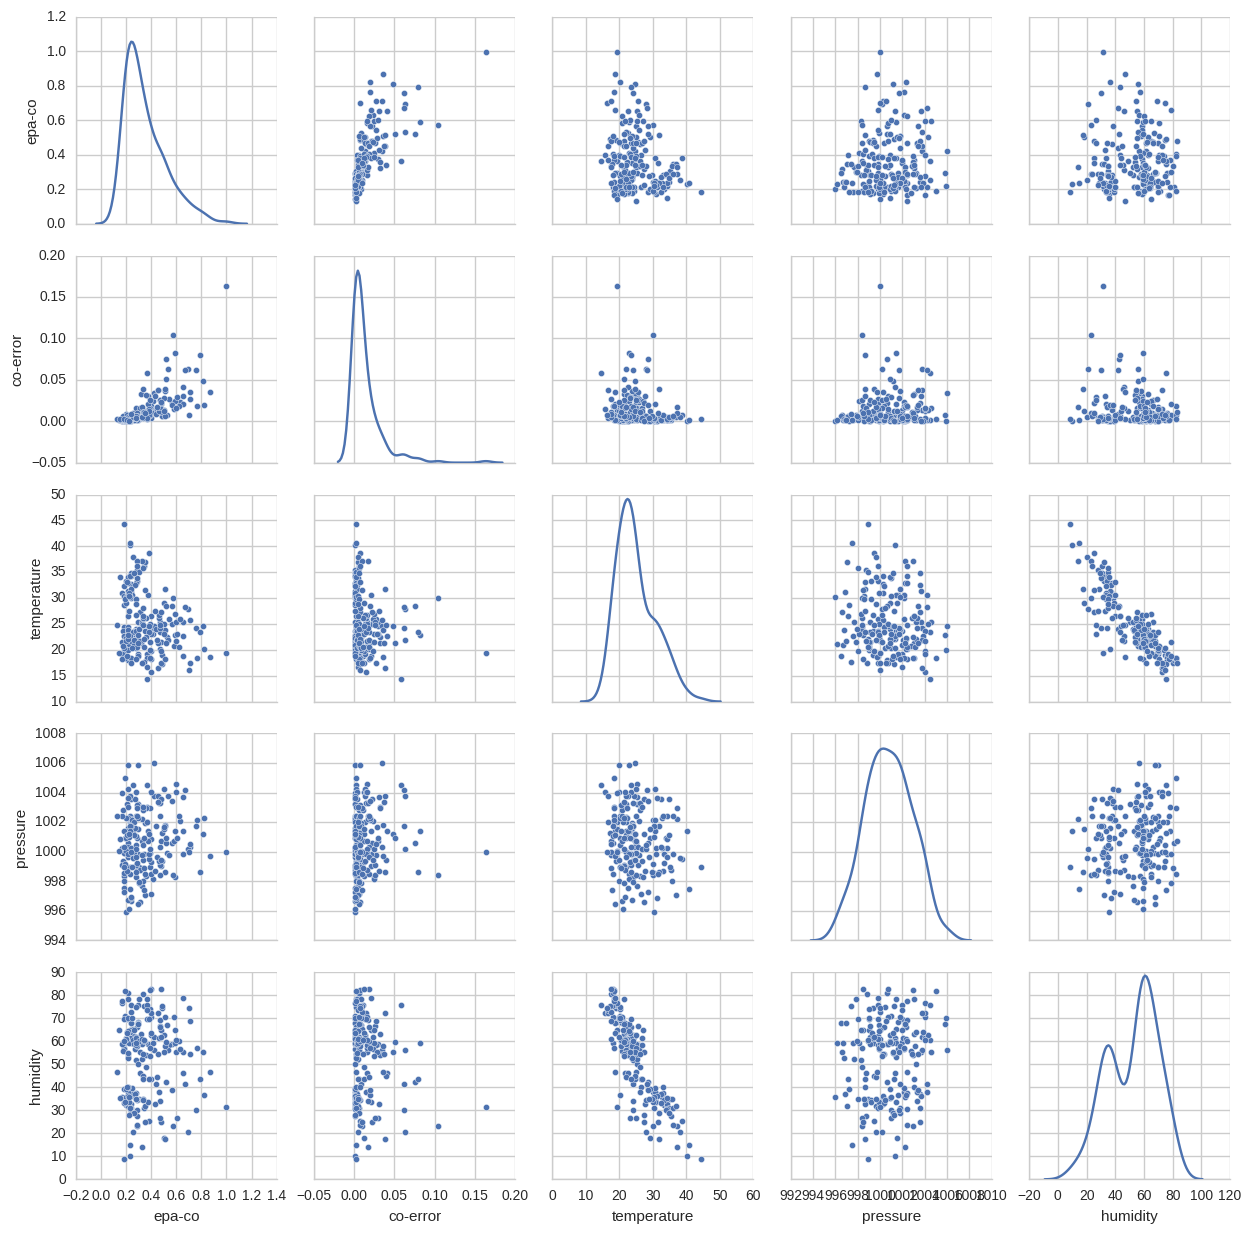

In [260]:
averaged = test_data.groupby(lambda x: (x.week, x.day, x.hour // 6)).mean()
sns.pairplot(averaged, vars=['epa-co','co-error', 'temperature', 'pressure', 'humidity'], diag_kind='kde')
plt.show()

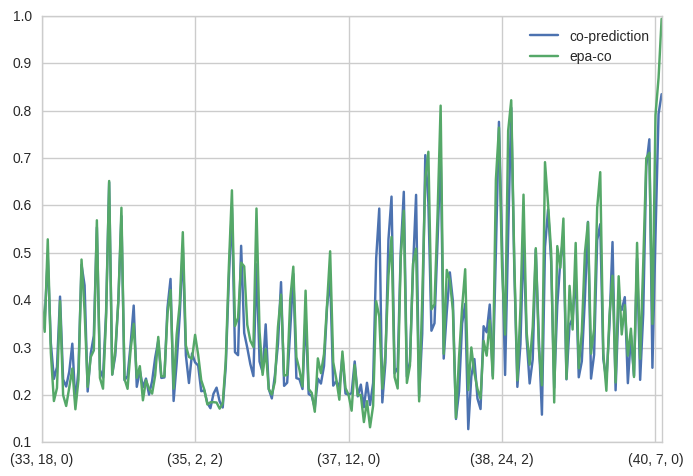

In [262]:
averaged = test_data.groupby(lambda x: (x.week, x.day, x.hour // 6)).mean()
plt.figure()
#averaged['co'].plot(secondary_y=True)
averaged['co-prediction'].plot()
averaged['epa-co'].plot()
#averaged['co-prediction'].plot(secondary_y=True)
plt.legend(loc='best')
plt.show()

Linear[1]: 9.532111
Linear[2]: 43.979014
Linear[3]: 3329.415989
Ridge[1]: 9.532116
Ridge[2]: 32.317233
Ridge[3]: 138.812126
Lasso[1]: 9.616654
Lasso[2]: 9.560751
Lasso[3]: 10.233932
f(x) = -7.30E-02 * o3-A + 3.42E-01 * o3-W + 1.47E-02 * co-A + -1.48E-01 * co-W + 2.07E+00 * temperature + 6.64E-02 * humidity + -88.7715850759


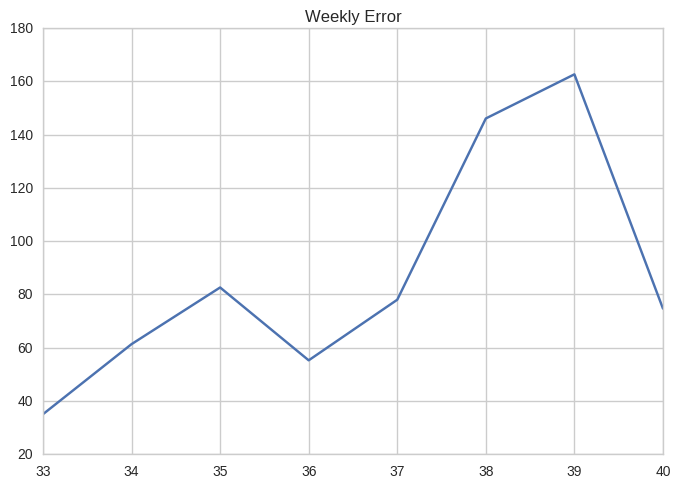

In [273]:
error, results = benchmark_full(*O3_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
plt.show()
test_data['o3-error'] = results[1]
train_data['o3-error'] = (results[2].predict(train_data[O3_FEATURES[0]]) - train_data[O3_FEATURES[1]])
test_data['o3-prediction'] = results[2].predict(test_data[O3_FEATURES[0]])
train_data['o3-prediction'] = results[2].predict(train_data[O3_FEATURES[0]])

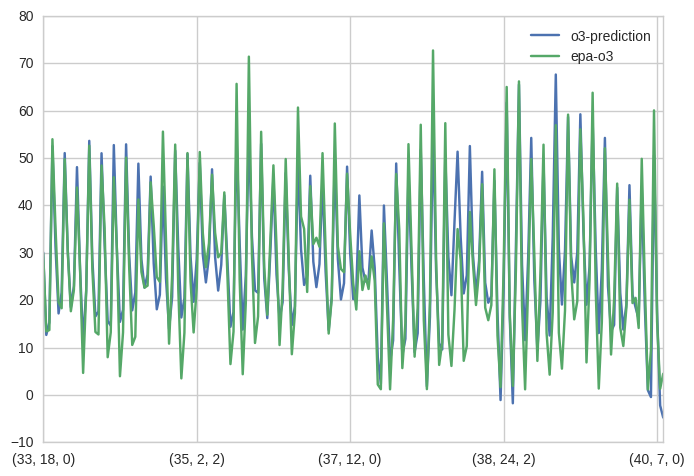

In [274]:
averaged = test_data.groupby(lambda x: (x.week, x.day, x.hour // 6)).mean()
plt.figure()
#averaged['co'].plot(secondary_y=True)
averaged['o3-prediction'].plot()
averaged['epa-o3'].plot()
#averaged['co-prediction'].plot(secondary_y=True)
plt.legend(loc='best')
plt.show()

Linear[1]: 6.744822
Linear[2]: 33.670780
Linear[3]: 464.567221
Ridge[1]: 6.744821
Ridge[2]: 16.392363
Ridge[3]: 35.876110
Lasso[1]: 7.048241
Lasso[2]: 6.361582
Lasso[3]: 6.586073
f(x) = 4.73E-04 * o3-A^2 + -6.32E-04 * o3-A * o3-W + -2.81E-05 * o3-A * no2-A + 9.31E-05 * o3-A * no2-W + 1.22E-03 * o3-A * co-A + 7.92E-04 * o3-A * co-W + -1.59E-03 * o3-A * temperature + -1.31E-04 * o3-A * humidity + 2.21E-04 * o3-W^2 + -1.06E-04 * o3-W * no2-A + -9.88E-05 * o3-W * no2-W + -1.60E-03 * o3-W * co-A + -4.89E-05 * o3-W * co-W + 9.23E-04 * o3-W * temperature + -1.06E-04 * o3-W * humidity + -6.73E-04 * no2-A^2 + 2.39E-04 * no2-A * no2-W + -1.30E-03 * no2-A * co-A + 3.04E-04 * no2-A * co-W + -4.77E-04 * no2-A * temperature + -9.53E-05 * no2-A * humidity + -8.44E-05 * no2-W^2 + 2.94E-03 * no2-W * co-A + -4.19E-04 * no2-W * co-W + -9.49E-04 * no2-W * temperature + 1.93E-04 * no2-W * humidity + -9.38E-04 * co-A^2 + 4.75E-04 * co-A * co-W + 1.76E-04 * co-A * temperature + -1.66E-04 * co-A * humidity + 

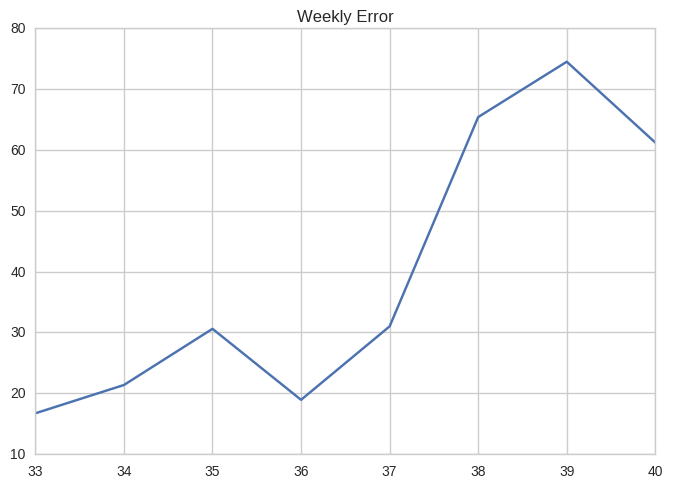

In [275]:
error, results = benchmark_full(*NO2_FEATURES)
results[1].groupby(lambda x: x.week).mean().plot()
plt.title("Weekly Error")
plt.show()
test_data['no2-error'] = results[1]
train_data['no2-error'] = (results[2].predict(train_data[NO2_FEATURES[0]]) - train_data[NO2_FEATURES[1]])
test_data['no2-prediction'] = results[2].predict(test_data[NO2_FEATURES[0]])
train_data['no2-prediction'] = results[2].predict(train_data[NO2_FEATURES[0]])

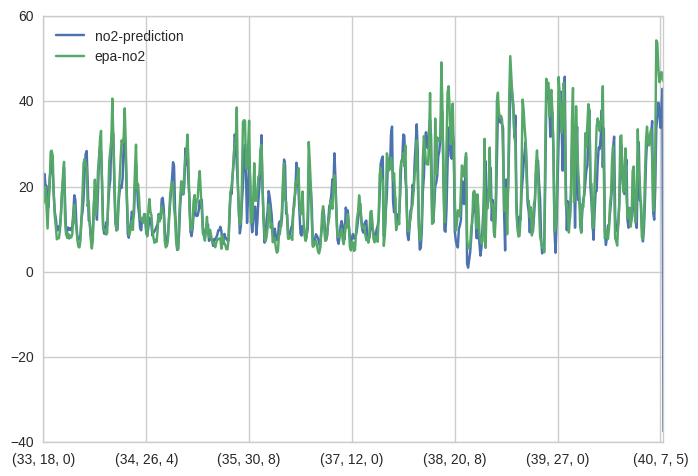

In [277]:
averaged = test_data.groupby(lambda x: (x.week, x.day, x.hour // 2)).mean()
plt.figure()
#averaged['co'].plot(secondary_y=True)
averaged['no2-prediction'].plot()
averaged['epa-no2'].plot()
#averaged['co-prediction'].plot(secondary_y=True)
plt.legend(loc='best')
plt.show()

0.0771496377858
0.0818787651963
0.0861972486027
0.0815735669657
0.128035971016
0.120451670133
0.15345449606
0.179413063557


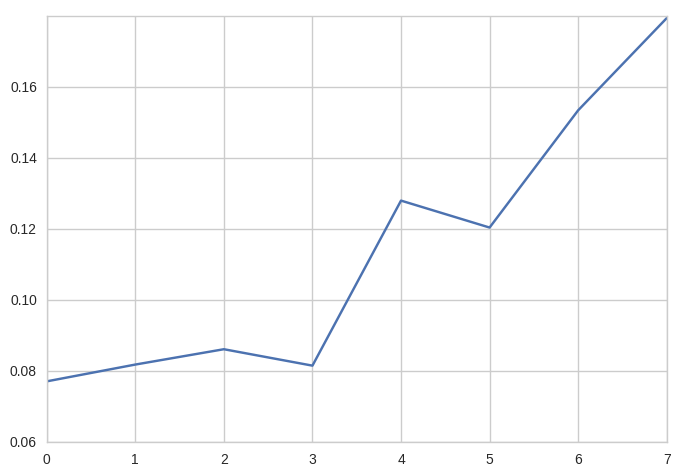

In [269]:
errors = []
train_data, test_data = data.loc[:"2016-08-18"], data.loc["2016-08-18":]
two_week_data = test_data.groupby(lambda x: x.week)
for week, two_weeks in two_week_data:
    days = [b for a, b in two_weeks.groupby(lambda x: x.day)]
    train, test = days[:1], days[1:]
    train_data = pd.concat([train_data] + train)
    test = pd.concat(test)
    cf = make_pipeline(PolynomialFeatures(3), Lasso())
    cf.fit(train_data[CO_FEATURES[0]], train_data[CO_FEATURES[1]])
    error = ((test[CO_FEATURES[1]] - cf.predict(test[CO_FEATURES[0]])) ** 2).mean()
    print(np.sqrt(error.mean()))
    errors.append(np.sqrt(error.mean()))
plt.plot(errors)
plt.show()

In [24]:
initial_range

DatetimeIndex(['2016-08-03 17:28:00', '2016-08-04 17:28:00',
               '2016-08-05 17:28:00', '2016-08-06 17:28:00',
               '2016-08-07 17:28:00', '2016-08-08 17:28:00',
               '2016-08-09 17:28:00', '2016-08-10 17:28:00',
               '2016-08-11 17:28:00', '2016-08-12 17:28:00',
               '2016-08-13 17:28:00', '2016-08-14 17:28:00',
               '2016-08-15 17:28:00', '2016-08-16 17:28:00'],
              dtype='datetime64[ns]', freq='D')

# Making functions for other boards

In [223]:
def get_functions(name):
    data = pd.read_csv(DATA_DIR / "csv" / name, index_col='datetime', parse_dates=True)
    co_classifier = Pipeline([('poly', PolynomialFeatures(3)), ('cf', Lasso())])
    co_classifier.fit(data[CO_FEATURES[0]], data[CO_FEATURES[1]])
    print("CO")
    print("===========")
    print_function((None, None, co_classifier, CO_FEATURES[0]))
    print()
    
    o3_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    o3_classifier.fit(data[O3_FEATURES[0]], data[O3_FEATURES[1]])
    print("O3")
    print("===========")
    print_function((None, None, o3_classifier, O3_FEATURES[0]))
    print()
    
    no2_classifier = Pipeline([('poly', PolynomialFeatures(2)), ('cf', Lasso())])
    no2_classifier.fit(data[NO2_FEATURES[0]], data[NO2_FEATURES[1]])
    print("NO2")
    print("===========")
    print_function((None, None, no2_classifier, NO2_FEATURES[0]))
    print()

In [278]:
get_functions("B2.csv")

NameError: name 'get_functions' is not defined

In [225]:
get_functions("B5.csv")

CO
f(x) = 4.76E-07 * co-A * co-W + 1.13E-09 * co-W^2 + -2.81E-07 * co-A^3 + -7.94E-09 * co-A^2 * co-W + 5.15E-07 * co-A^2 * temperature + 2.23E-08 * co-A^2 * humidity + -1.15E-11 * co-A * co-W^2 + 6.97E-09 * co-A * co-W * temperature + -1.89E-09 * co-A * co-W * humidity + 4.33E-07 * co-A * temperature * humidity + 2.32E-07 * co-A * humidity^2 + 2.04E-13 * co-W^3 + -1.89E-12 * co-W^2 * temperature + -6.33E-12 * co-W^2 * humidity + 2.03E-09 * co-W * temperature^2 + -1.18E-09 * co-W * temperature * humidity + -5.98E-10 * co-W * humidity^2 + -1.83E-07 * humidity^3

O3
f(x) = -2.60E-03 * co-W + 8.60E-04 * o3-A^2 + -1.72E-04 * o3-A * o3-W + 3.59E-05 * o3-A * co-A + -5.71E-08 * o3-A * co-W + -6.90E-05 * o3-W^2 + 5.42E-05 * o3-W * co-A + -4.17E-07 * o3-W * co-W + -8.62E-05 * o3-W * humidity + -2.44E-05 * co-A^2 + 3.69E-07 * co-A * co-W + 7.00E-09 * co-W^2 + -9.25E-09 * co-W * temperature + -3.01E-07 * co-W * humidity

NO2
f(x) = -7.10E-04 * co-W + 1.79E-04 * o3-A * o3-W + 6.18E-06 * o3-A * no2

In [226]:
get_functions("B8.csv")

CO
f(x) = -4.42E-07 * co-A^2 + -4.37E-07 * co-A * co-W + 1.90E-06 * co-A * temperature + -1.51E-07 * co-W^2 + -9.61E-07 * co-W * temperature + 1.27E-05 * co-W * humidity + -1.51E-11 * co-A^3 + 1.15E-10 * co-A^2 * co-W + -2.86E-10 * co-A^2 * temperature + 2.87E-09 * co-A^2 * humidity + 2.03E-10 * co-A * co-W^2 + -4.81E-09 * co-A * co-W * temperature + 9.84E-09 * co-A * co-W * humidity + 2.08E-08 * co-A * temperature^2 + -3.88E-08 * co-A * temperature * humidity + -1.47E-07 * co-A * humidity^2 + 2.47E-10 * co-W^3 + -4.54E-09 * co-W^2 * temperature + -1.14E-08 * co-W^2 * humidity + 2.53E-08 * co-W * temperature^2 + 1.24E-07 * co-W * temperature * humidity + 5.66E-08 * co-W * humidity^2 + -4.02E-08 * temperature^3 + -1.52E-07 * temperature^2 * humidity + -1.05E-07 * temperature * humidity^2 + 7.34E-07 * humidity^3

O3
f(x) = -3.21E-03 * o3-A^2 + 2.85E-03 * o3-A * o3-W + 6.97E-04 * o3-A * co-A + 1.60E-04 * o3-A * co-W + 5.83E-04 * o3-A * temperature + -1.95E-03 * o3-A * humidity + -1.97E-04

In [227]:
get_functions("B9.csv")

CO
f(x) = 9.37E-06 * co-A^2 + 6.09E-06 * co-A * co-W + -1.96E-04 * co-A * temperature + 5.38E-05 * co-A * humidity + -1.27E-07 * co-W^2 + 1.00E-05 * co-W * humidity + -3.01E-05 * humidity^2 + -1.35E-09 * co-A^3 + -4.40E-09 * co-A^2 * co-W + -7.11E-08 * co-A^2 * temperature + -6.14E-08 * co-A^2 * humidity + -9.04E-11 * co-A * co-W^2 + -1.29E-07 * co-A * co-W * temperature + -5.19E-08 * co-A * co-W * humidity + 4.20E-06 * co-A * temperature^2 + -1.28E-06 * co-A * temperature * humidity + 1.09E-07 * co-A * humidity^2 + -2.63E-11 * co-W^3 + 5.45E-10 * co-W^2 * temperature + 2.89E-08 * co-W^2 * humidity + -5.38E-07 * co-W * temperature^2 + 1.89E-06 * co-W * temperature * humidity + -8.66E-07 * co-W * humidity^2 + 4.04E-07 * temperature^3 + -2.10E-05 * temperature^2 * humidity + 3.82E-06 * temperature * humidity^2 + 5.37E-07 * humidity^3

O3
f(x) = -6.03E-02 * o3-A + -5.17E-01 * co-A + -1.04E-01 * co-W + -8.70E-01 * humidity + 2.08E-05 * o3-A^2 + 2.85E-05 * o3-A * o3-W + -3.38E-03 * o3-A * c

In [228]:
get_functions("B10.csv")

CO
f(x) = 1.73E-06 * co-A^2 + 2.75E-07 * co-A * co-W + -1.51E-06 * co-A * humidity + 2.91E-07 * co-W^2 + 3.64E-05 * co-W * humidity + -3.29E-05 * humidity^2 + -3.80E-10 * co-A^3 + -2.12E-11 * co-A^2 * co-W + 1.44E-09 * co-A^2 * temperature + 4.96E-09 * co-A^2 * humidity + -1.52E-10 * co-A * co-W^2 + -1.90E-08 * co-A * co-W * temperature + 1.17E-08 * co-A * co-W * humidity + 7.21E-08 * co-A * temperature^2 + 4.84E-07 * co-A * temperature * humidity + -3.03E-07 * co-A * humidity^2 + 3.38E-10 * co-W^3 + -4.25E-08 * co-W^2 * temperature + -2.91E-08 * co-W^2 * humidity + -1.80E-06 * co-W * temperature^2 + 4.08E-06 * co-W * temperature * humidity + -6.07E-07 * co-W * humidity^2 + 9.22E-06 * temperature^3 + -1.14E-05 * temperature^2 * humidity + -2.03E-05 * temperature * humidity^2 + 5.32E-06 * humidity^3

O3
f(x) = -2.88E-02 * co-W + -8.53E-04 * o3-A^2 + 3.92E-04 * o3-A * o3-W + -3.23E-04 * o3-A * co-A + -1.39E-05 * o3-A * co-W + 1.31E-02 * o3-A * temperature + -1.66E-03 * o3-A * humidity + 